# Import Library

In [2]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import numpy as np
import pandas as pd

import pathlib
import shutil
import tempfile

from  IPython import display
from matplotlib import pyplot as plt

## Loading TensorBoard

In [3]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/models

## Plotter Function

In [4]:
from itertools import cycle
def plotter(history_hold, metric = 'binary_crossentropy', ylim=[0.0, 1.0]):
  cycol = cycle('bgrcmk')
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0,len(y_val))

    c=next(cycol)

    plt.plot(x_train, y_train, c+'-', label=name+'_train')
    plt.plot(x_train, y_val, c+'--', label=name+'_val')

  plt.legend()
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)

In [5]:
!pip install wordcloud

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


## Reading train and test CSV

In [6]:
# Read train and test dataset.
with open('stance-dataset/train.csv','r',encoding='ISO-8859-1') as train:
 train_data = pd.read_csv(train)
 
with open('stance-dataset/test.csv','r',encoding='ISO-8859-1') as test:
 test_data = pd.read_csv(test)
 
train.close()
test.close()

In [7]:
train_data.head(10)

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos
5,Hillary can not win. Here's hoping the Dems of...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
6,Respect FOR the law and respect BY the law Yes...,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,pos
7,I don't want to be appointed to an Ambassador ...,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,neg
8,#StopHillary2016 @HillaryClinton if there was ...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
9,@HillaryClinton End lawless #ClintonFoundation...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg


In [8]:
test_data.head(10)

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,He who exalts himself shall be humbled; a...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
1,RT @prayerbullets: I remove Nehushtan -previou...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,other
2,@Brainman365 @heidtjj @BenjaminLives I have so...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
3,#God is utterly powerless without Human interv...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@David_Cameron Miracles of #Multiculturalism...,Atheism,AGAINST,2. The tweet does NOT expresses opinion about ...,neg
5,This world needs a tight group hug. Tight enou...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
6,"Morality is not derived from religion, it prec...",Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
7,A Godly husband - knows you - trusts you - lo...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
8,@SecularDutchess I'll be your huckleberry @Dea...,Atheism,AGAINST,2. The tweet does NOT expresses opinion about ...,other
9,#BIBLE = Big Irrelevant Book of Lies and Exagg...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,neg


In [9]:
train_data['Target'].unique()

array(['Hillary Clinton', 'Legalization of Abortion', 'Atheism',
       'Climate Change is a Real Concern', 'Feminist Movement'],
      dtype=object)

In [10]:
train_data['Stance'].unique()

array(['AGAINST', 'FAVOR', 'NONE'], dtype=object)

### Exploratory Data Analysis

In [11]:
train_data.describe()

,Tweet,Target,Stance,Opinion Towards,Sentiment
count,2914,2914,2914,2914,2914
unique,2914,5,3,3,3
top,@cschultzwx there has been a ton of lightning ...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
freq,1,689,1395,1716,1762


In [12]:
stance = train_data.groupby('Stance')

stance.describe().head()

Tweet                                                                 \
        count unique                                                top freq   
Stance                                                                         
AGAINST  1395   1395  I love the smell of Hillary in the morning. It...    1   
FAVOR     753    753  Good morning @JustinTrudeau. Do you plan to te...    1   
NONE      766    766  @cschultzwx there has been a ton of lightning ...    1   

        Target                                               Opinion Towards  \
         count unique                               top freq           count   
Stance                                                                         
AGAINST   1395      5                   Hillary Clinton  393            1395   
FAVOR      753      5  Climate Change is a Real Concern  212             753   
NONE       766      5                   Hillary Clinton  178             766   

                                                                         \
        unique                                                top  freq   
Stance                                                                    
AGAINST      3  1.  The tweet explicitly expresses opinion abo...  1000   
FAVOR        3  1.  The tweet explicitly expresses opinion abo...   707   
NONE         3  2. The tweet does NOT expresses opinion about ...   598   

        Sentiment                   
            count unique  top freq  
Stance                              
AGAINST      1395      3  neg  931  
FAVOR         753      3  neg  420  
NONE          766      3  neg  411

In [13]:
train_data["Target"].value_counts()

Hillary Clinton                     689
Feminist Movement                   664
Legalization of Abortion            653
Atheism                             513
Climate Change is a Real Concern    395
Name: Target, dtype: int64

In [14]:
train_data["Stance"].value_counts()

AGAINST    1395
NONE        766
FAVOR       753
Name: Stance, dtype: int64

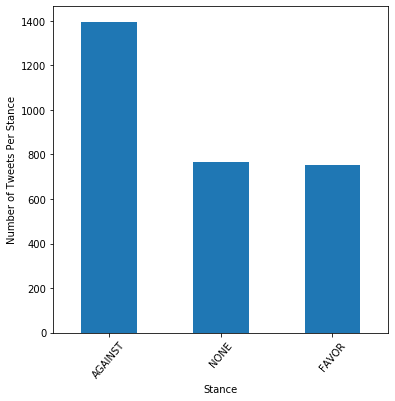

In [21]:
plt.figure(figsize=(6,6))
stance.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Stance")
plt.ylabel("Number of Tweets Per Stance")
plt.show()

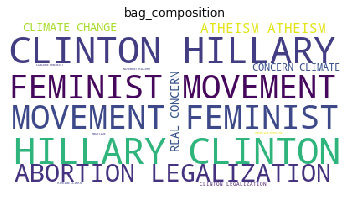

In [37]:
## Word Cloud
from wordcloud import WordCloud, STOPWORDS

def wordcloud(dataframe):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",stopwords=stopwords).generate(" ".join([i for i in dataframe.str.upper()]))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("bag_composition")

wordcloud(train_data['Target'])